# Diagnosis

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns
import tifffile
import SimpleITK as sitk
import re
from datetime import datetime
from brokenaxes import brokenaxes
from scipy import stats
from sklearn import metrics

from mousechd.classifier.utils import calculate_metrics

import matplotlib as mpl
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.linewidth'] = 1.5

HOME = os.environ.get("HOME")
SAVEDIR = f'{HOME}/DATA/INCEPTION_2020-CHD/Mice/PAPER/FIGURES/Fig04/Components'
os.makedirs(SAVEDIR, exist_ok=True)
DATADIR = f'{HOME}/DATA/INCEPTION_2020-CHD/Mice/DATA/CTs'
PROCESSDIR = f'{DATADIR}/processed/Imagine'
RAWDIR = f"{HOME}/DATA/INCEPTION_2020-CHD/Mice/DATA/CTs/raw/Imagine"
OUTDIR = f"{HOME}/DATA/INCEPTION_2020-CHD/Mice/OUTPUTS/Classifier"

## Cross-validation

In [26]:
def load_latest_meta(path):
    metafiles = sorted([x for x in os.listdir(path) if bool(re.search("(metadata_\d+.csv)+", x))])

    return pd.read_csv(os.path.join(path, metafiles[-1]))

def load_latest_term(path):
    metafiles = sorted([x for x in os.listdir(path) if bool(re.search("(terminology_\d+.csv)+", x))])

    return pd.read_csv(os.path.join(path, metafiles[-1]), sep=";")
    

df = load_latest_meta(PROCESSDIR)

df = df[~df["heart_name"].isin(["N_261h", "NH_229m"])]
terms = load_latest_term(os.path.join(RAWDIR, 'metadata'))
df = df[df["Stage"] != "E13.5"]

transpose_df = df.set_index("heart_name").transpose()
transpose_df.reset_index(inplace=True)
transpose_df["index"] = transpose_df["index"].map(terms.set_index("Diagnostic").to_dict()["Kingdom"]).fillna(transpose_df["index"])

df = transpose_df.groupby("index").agg("sum").transpose()
df.reset_index(inplace=True)
df.drop(labels=["Cardiomyopathy",
                "Pulmonary Venous Anomalies",
               "Systemic Venous Anomalies "], axis=1, inplace=True)
diseases = [x for x in df.columns if x not in ["heart_name", "Stage", "Normal heart"]]
df = df[["heart_name",
        "Stage"] + diseases]

df_cp = df.copy()
df_cp["stratify"] = df_cp[diseases].astype(int).astype(str).agg("-".join, axis=1)

stage_dict = df_cp.set_index("heart_name").to_dict()['Stage']
volume_df = pd.read_csv(f"{DATADIR}/processed/Imagine/volumes.csv")
volume_dict = volume_df.set_index('heart_name').to_dict()['volume']

def load_fold(path, fold, stage_dict, volume_dict):
    result = pd.read_csv(f"{path}/{fold}/results/best_model.hdf5/test.csv")
    result['stage'] = result['heart_name'].map(stage_dict)
    result['volume'] = result['heart_name'].map(volume_dict)
    result["fold"] = fold
    
    return result

dfs = []
for i in range(1,6):
    fold_df = load_fold(OUTDIR, f"F{i}", stage_dict, volume_dict)
    print(f"===FOLD {i}===")
    print(calculate_metrics(fold_df.prob, fold_df.label))
    dfs.append(fold_df)

full_df = pd.concat(dfs, ignore_index=True)
calculate_metrics(full_df.prob, full_df.label)

===FOLD 1===
{'acc': 0.9285714285714286, 'bal_acc': 0.9125, 'all_sens': array([0.875]), 'all_spec': array([0.95]), 'all_f1': array([0.875]), 'all_auc': array([0.95]), 'sens': 0.875, 'spec': 0.95, 'f1': 0.875, 'auc': 0.95}
===FOLD 2===
{'acc': 0.9642857142857143, 'bal_acc': 0.9761904761904762, 'all_sens': array([1.]), 'all_spec': array([0.95238095]), 'all_f1': array([0.93333333]), 'all_auc': array([1.]), 'sens': 1.0, 'spec': 0.9523809523809523, 'f1': 0.9333333333333333, 'auc': 1.0}
===FOLD 3===
{'acc': 0.9642857142857143, 'bal_acc': 0.9375, 'all_sens': array([0.875]), 'all_spec': array([1.]), 'all_f1': array([0.93333333]), 'all_auc': array([0.95]), 'sens': 0.875, 'spec': 1.0, 'f1': 0.9333333333333333, 'auc': 0.95}
===FOLD 4===
{'acc': 0.8928571428571429, 'bal_acc': 0.8875, 'all_sens': array([0.875]), 'all_spec': array([0.9]), 'all_f1': array([0.82352941]), 'all_auc': array([0.89375]), 'sens': 0.875, 'spec': 0.9, 'f1': 0.823529411764706, 'auc': 0.89375}
===FOLD 5===
{'acc': 1.0, 'bal_acc

{'acc': 0.9496402877697842,
 'bal_acc': 0.9407243355914539,
 'all_sens': array([0.92105263]),
 'all_spec': array([0.96039604]),
 'all_f1': array([0.90909091]),
 'all_auc': array([0.96508598]),
 'sens': 0.9210526315789473,
 'spec': 0.9603960396039604,
 'f1': 0.9090909090909091,
 'auc': 0.9650859822824388}

In [28]:
full_df[(full_df["label"]==0) & (full_df["pred"]==1)]

,heart_name,label,prob,pred,stage,volume,fold
22,RP5D1,0,0.532020,1,E18.5,7.984263,F1
34,RP5G1,0,0.672097,1,E18.5,18.433935,F2
97,N_255h,0,0.508951,1,P0,20.527855,F4
108,NI_7,0,0.945211,1,P0,12.932471,F4


In [7]:
palette = {
    "Fold 1": "#C3D54D",
    "Fold 2": "#FFAB3F",
    "Fold 3": "#0098A7",
    "Fold 4": "#EA9999",
    "Fold 5": "#0AFEFF"
}


def decode_label(x):
    if x==0:
        return "Normal"
    else:
        return "CHD"

def plot_cm_binary(df, normalize=True, fmt='.2f', cmap="Blues", annot_kws={"size": 15}, label_size=15, tick_size=12):
    cm = pd.crosstab(df["label"], df["pred"])
    labels = list(cm.index)
    
    if normalize:
        for x in labels:
            cm.loc[x, :] = cm.loc[x, :]/cm.loc[x, :].sum()
        
    sns.heatmap(cm, annot=True, annot_kws=annot_kws, fmt=fmt, cmap=cmap)
    plt.ylabel("Ground truth", fontsize=label_size, weight='bold')
    plt.xlabel("\nPrediction", fontsize=label_size, weight='bold')
    plt.yticks(va="center", fontsize=tick_size)
    plt.xticks(ha="center", fontsize=tick_size);


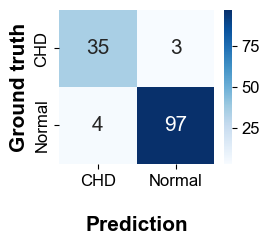

In [11]:
df = full_df.copy()
df["label"] = df["label"].map(decode_label)
df["pred"] = df["pred"].map(decode_label)
plt.subplots(figsize=(2.5,2))
plot_cm_binary(
    df,
    normalize=False,
    fmt='d'
)

today = datetime.now().strftime('%Y%m%d')
# plt.savefig(os.path.join(f'{SAVEDIR}/confusion_matrix_{today}.svg'), bbox_inches='tight', dpi=1000)

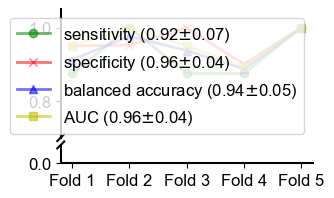

In [12]:
df = pd.DataFrame({"fold": ["Fold 1","Fold 2", "Fold 3", "Fold 4", "Fold 5"]})
df["sensitivity"] = [metrics.recall_score(x["label"], x["pred"], pos_label=1) for x in dfs]
df["specificity"] = [metrics.recall_score(x["label"], x["pred"], pos_label=0) for x in dfs]
df["balanced accuracy"] = [metrics.balanced_accuracy_score(x["label"], x["pred"]) for x in dfs]
df["AUC"] = [metrics.roc_auc_score(x["label"], x["prob"]) for x in dfs]
df.set_index("fold", inplace=True)

markers = ("o", "x", "^", 's')
colors = ('g', 'r', 'b', 'y')
metrics_name = df.columns.to_list()

plt.figure(figsize=(3.25, 2))
ax = brokenaxes(ylims=((0,.05), (0.7, 1.05)), hspace=0.1)
for i, metric in enumerate(metrics_name):
    ax.plot(
        df[metric],"{}-".format(markers[i]), 
        label=metric + " ({:.2f}".format(np.round(df[metric].mean(),2)) + "$\pm$" + "{:.2f})".format(df[metric].std()), 
        linewidth=2, 
        alpha=0.55,
        color=colors[i],
    )
    
ax.legend(fontsize=12)

today = datetime.now().strftime('%Y%m%d')
# plt.savefig(os.path.join(f'{SAVEDIR}/crossclf_metrics_{today}.svg'), bbox_inches='tight', dpi=1000)

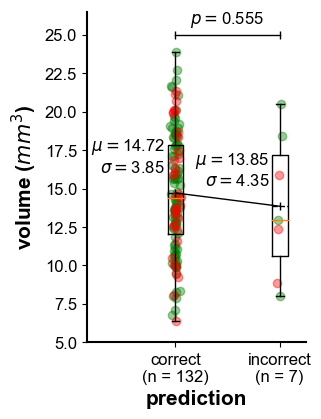

In [14]:
df_stats = pd.concat(dfs, ignore_index=True)
df_stats['prediction'] = (df_stats['label']==df_stats['pred'])*1
df_stats['prediction'] = df_stats['prediction'].map({1: "correct", 0: "incorrect"})
df_stats['label'] = df_stats['label'].map({0: 'Normal', 1: 'CHD'})

volume_df = df_stats.copy()
volume_df["stage"] = volume_df['prediction']

vals, names, xs, labels = [], [], [], []

stages = ["correct","incorrect"]

for i, stage in enumerate(stages):
    vals.append(volume_df[volume_df["stage"]==stage]["volume"].values)
    labels.append(volume_df[volume_df["stage"]==stage]["label"].values)
    names.append("{}\n(n = {})".format(stage, len(volume_df[volume_df["stage"]==stage])))
    xs.append(np.random.normal(i+1, 0.02, volume_df[volume_df["stage"]==stage]["volume"].values.shape[0]))
    
plt.figure(figsize=(3,4))
plt.boxplot(vals, labels=names, 
            meanline=True, showmeans=True,
            meanprops={'color': 'k'}
           )

palette = ["r", "g"]
for x, val, label in zip(xs, vals, labels):
    normal_idx = (label == "Normal")
    ab_idx = (label == "CHD")
    plt.scatter(x[normal_idx], val[normal_idx], alpha=0.4, color="g", label="Normal")
    plt.scatter(x[ab_idx], val[ab_idx], alpha=0.4, color="r", label="CHD")
    
# Mean
plt.text(0.9,vals[0].mean(),
         r'$\mu=$' + '{:.2f}\n'.format(vals[0].mean()) + r'$\sigma=$' + '{:.2f}\n'.format(np.std(vals[0])),
         ha="right", va="bottom",
         fontsize=12
        );

plt.text(1.9,vals[1].mean(),
         r'$\mu=$' + '{:.2f}\n'.format(vals[1].mean()) + r'$\sigma=$' + '{:.2f}\n'.format(np.std(vals[1])),
         ha="right", va="bottom",
         fontsize=12
        );
plt.plot([1,2], [vals[0].mean(), vals[1].mean()], '|-k', linewidth=1)

# test
plt.plot([1,2], [25,25], linewidth=1, c="k", marker="|")

# plt.text(1.5,27,
#         #  "t-test",
#         #  "Wilcoxon signed-rank test",
#          "Mann-Whitney U test",
#          weight="bold",
#          ha="center", va="center",
#          fontsize=12
#         );

# plt.text(1.5,25.8,
#          r'$p=$' + '{:.3f} '.format(
#             #  stats.ttest_ind(vals[0], vals[1]).pvalue
#             #  stats.wilcoxon(vals[0], vals[1]).pvalue
#              stats.mannwhitneyu(vals[0], vals[1]).pvalue
#          ) + "(n1 = {}, n2 = {})".format(len(vals[0]), len(vals[1])),
#          ha="center", va="center",
#          fontsize=12
#         );
plt.text(1.5,26,
         r'$p=$' + '{:.3f} '.format(
            #  stats.ttest_ind(vals[0], vals[1]).pvalue
            #  stats.wilcoxon(vals[0], vals[1]).pvalue
             stats.mannwhitneyu(vals[0], vals[1]).pvalue
         ),
         ha="center", va="center",
         fontsize=12
        );

# plt.ylim(4.5,27)
# plt.xlim(0.15, 2.2)
plt.ylim(5, 26.5)
plt.xlim(0.15, 2.25)
plt.ylabel("volume ($mm^{3}$)", fontsize=15, weight='bold')
plt.xlabel("prediction", fontsize=15, weight="bold")
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
today = datetime.now().strftime('%Y%m%d')
# plt.savefig(os.path.join(f'{SAVEDIR}/volume_clf_mwt_{today}.svg'), bbox_inches='tight', dpi=1000)

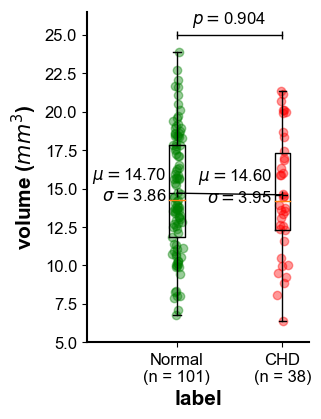

In [15]:
today = datetime.now().strftime('%Y%m%d')

vals, names, xs, labels = [], [], [], []

# stages = ["E18.5","P0"]
stages = ["Normal", "CHD"]

for i, stage in enumerate(stages):
    # vals.append(volume_df[volume_df["stage"]==stage]["volume"].values)
    # labels.append(volume_df[volume_df["stage"]==stage]["label"].values)
    # names.append("{}\n(n = {})".format(stage, len(volume_df[volume_df["stage"]==stage])))
    # xs.append(np.random.normal(i+1, 0.02, volume_df[volume_df["stage"]==stage]["volume"].values.shape[0]))
    vals.append(volume_df[volume_df["label"]==stage]["volume"].values)
    labels.append(volume_df[volume_df["label"]==stage]["label"].values)
    names.append("{}\n(n = {})".format(stage, len(volume_df[volume_df["label"]==stage])))
    xs.append(np.random.normal(i+1, 0.02, volume_df[volume_df["label"]==stage]["volume"].values.shape[0]))
    
# plt.figure(figsize=(3,3.25))
plt.figure(figsize=(3,4))
plt.boxplot(vals, labels=names, 
            meanline=True, showmeans=True,
            meanprops={'color': 'k'}
           )

palette = ["r", "g"]
for x, val, label in zip(xs, vals, labels):
    normal_idx = (label == "Normal")
    ab_idx = (label == "CHD")
    plt.scatter(x[normal_idx], val[normal_idx], alpha=0.4, color="g", label="Normal")
    plt.scatter(x[ab_idx], val[ab_idx], alpha=0.4, color="r", label="CHD")
    
# Mean
plt.text(0.9,vals[0].mean(),
         r'$\mu=$' + '{:.2f}\n'.format(vals[0].mean()) + r'$\sigma=$' + '{:.2f}\n'.format(np.std(vals[0])),
         ha="right", va="center",
         fontsize=12
        );

plt.text(1.9,vals[1].mean(),
         r'$\mu=$' + '{:.2f}\n'.format(vals[1].mean()) + r'$\sigma=$' + '{:.2f}\n'.format(np.std(vals[1])),
         ha="right", va="center",
         fontsize=12
        );
plt.plot([1,2], [vals[0].mean(), vals[1].mean()], '|-k', linewidth=1)

# test
plt.plot([1,2], [25,25], linewidth=1, c="k", marker="|")

# plt.text(1.5,27,
#         #  "t-test",
#         #  "Wilcoxon signed-rank test",
#          "Mann-Whitney U test",
#          weight="bold",
#          ha="center", va="center",
#          fontsize=12
#         );

plt.text(1.5,26,
         r'$p=$' + '{:.3f} '.format(
            #  stats.ttest_ind(vals[0], vals[1]).pvalue
             stats.mannwhitneyu(vals[0], vals[1]).pvalue
         ),
         ha="center", va="center",
         fontsize=12
        );


plt.ylim(5, 26.5)
plt.xlim(0.15, 2.25)
plt.ylabel("volume ($mm^3$)", fontsize=15, weight='bold')
plt.xlabel("label", fontsize=15, weight='bold')
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
# plt.savefig(os.path.join(SAVEDIR, f'volume_label_{today}.svg'), bbox_inches='tight', dpi=1000)

<Figure size 300x300 with 0 Axes>

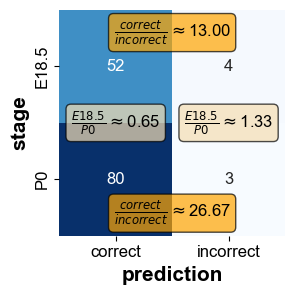

In [17]:
tb = pd.crosstab(df_stats["stage"], df_stats["prediction"])
plt.figure(figsize=(3,3))
plt.figure(figsize=(2.75,2.75))
sns.heatmap(tb, 
            annot=True, 
            annot_kws={"size": 12}, 
            fmt='d', 
            cmap="Blues",
            cbar=False
           )
chd_per_normal = tb["correct"]/tb["incorrect"]
e185_per_p0 = tb.loc["E18.5", :]/tb.loc["P0", :]

props1 = dict(boxstyle='round', facecolor='orange', alpha=0.7)
props2 = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
plt.text(1,0.2, 
         r'$\frac{correct}{incorrect}\approx$' + '{:.2f}'.format(chd_per_normal['E18.5']),
         fontsize=12, va='center', ha='center', bbox=props1)
plt.text(1,1.8, 
         r'$\frac{correct}{incorrect}\approx$' + '{:.2f}'.format(chd_per_normal['P0']),
         fontsize=12, va='center', ha='center', bbox=props1)

plt.text(0.5,1, 
         r'$\frac{E18.5}{P0}\approx$' + '{:.2f}'.format(e185_per_p0["correct"]),
         fontsize=12, va='center', ha='center', bbox=props2)
plt.text(1.5,1, 
         r'$\frac{E18.5}{P0}\approx$' + '{:.2f}'.format(e185_per_p0["incorrect"]),
         fontsize=12, va='center', ha='center', bbox=props2)

plt.xlabel('prediction', fontsize=15, weight='bold')
plt.ylabel('stage', fontsize=15, weight='bold')

plt.tight_layout(pad=0, h_pad=0, w_pad=0)

today = datetime.now().strftime('%Y%m%d')
# plt.savefig(f'{SAVEDIR}/stage_pred_contingency_{today}.svg', bbox_inches='tight', dpi=1000)

In [18]:
ChiSqResult = stats.chi2_contingency(tb)
ChiSqResult

Chi2ContingencyResult(statistic=0.2890282721796277, pvalue=0.5908439101909361, dof=1, expected_freq=array([[53.17985612,  2.82014388],
       [78.82014388,  4.17985612]]))

In [6]:
def cal_roc_components(df,thres=0.5, pos_label=1, neg_label=0):
    fpr, tpr, thresholds = metrics.roc_curve(df.label, df.prob, pos_label=pos_label, drop_intermediate=False)
    thres_loc = np.argmax(tpr - fpr)
    preds = [pos_label if x>thres else neg_label for x in df.prob]
    sens = metrics.recall_score(df.label,preds, pos_label=pos_label)
    spec = metrics.recall_score(df.label,preds, pos_label=neg_label)
    bal_acc = metrics.balanced_accuracy_score(df.label, preds)
    acc = metrics.accuracy_score(df.label, preds)
    auc = metrics.auc(fpr, tpr)
    
    return (fpr, tpr, thres_loc,
           sens, spec, bal_acc, acc, auc)

def plot_multi_roc_curves(df, 
                          colors=["#C2D54D","#FDAA40", "#0097A7", "#EA9999", "#00FFFF"],
                          pos_label=1, neg_label=0, thres=0.5,
                          auc_pos = [0.1,]
                         ):
    sens_ls, spec_ls, acc_ls, bal_acc_ls = [], [], [], []
    for i, fold in enumerate(list(df["fold"].unique())):
        f_df = df[df["fold"]==fold]
        fpr, tpr, thres_loc, sens, spec, bal_acc, acc, auc = cal_roc_components(f_df, thres=thres,
                                                                                pos_label=pos_label,
                                                                                neg_label=neg_label
                                                                               )
        
        sens_ls.append(sens)
        spec_ls.append(spec)
        acc_ls.append(acc)
        bal_acc_ls.append(bal_acc)
        plt.plot(fpr, tpr,linewidth=2, c=colors[i], label=fold)
#         idx = 40 + i*9
#         idx = 40 + 15*i
        idx = 10+i*4
        x = fpr[idx]
        y =tpr[idx]
        bbox_props = dict(boxstyle="round", fc=colors[i], ec="0.5", alpha=0.5)
        plt.text(x, y, "AUC = {:.2f}".format(auc),
             ha="center", va="center", size=12,bbox=bbox_props)
        
    metrics = [0.5, np.mean(sens_ls),np.std(sens_ls),
               np.mean(spec_ls),np.std(spec_ls),
               np.mean(acc_ls),np.std(acc_ls),
               np.mean(bal_acc_ls),np.std(bal_acc_ls)]
    plt.text(0.4,0.11,
             "Threshold: {:.4f}\nSensitivity: {:.2f} $\pm$ {:.2f}\nSpecificity: {:.2f}$\pm$ {:.2f}\nAccuracy: {:.2f}$\pm$ {:.2f}\nBalanced accuracy: {:.2f}$\pm$ {:.2f}".format(
                 *metrics),
             fontsize=12,
             ha="left",va="center",bbox=dict(facecolor='none', edgecolor='blue',boxstyle='round,pad=0.5'))
    
    plt.xlabel('1-specificity', fontsize=15, weight='bold')
    plt.ylabel('sensitivity', fontsize=15, weight='bold')
    plt.legend()
    
def plot_roc_curve(df, title=None,thres=None, pos_label=1, neg_label=0, stds=[], label="All folds"):
#     plt.figure(figsize=(10,10))
#     plt.plot([0, 1], [0, 1], 'k--')
    
    fpr, tpr, thresholds = metrics.roc_curve(df.label, df.prob, pos_label=pos_label, drop_intermediate=False)
    plt.plot(fpr, tpr,linewidth=2, c="k", label=label)
    thres_loc = np.argmax(tpr - fpr)
#     thres_loc = np.argmin((1 - tpr) ** 2 + fpr ** 2)
    plt.scatter(fpr[thres_loc],tpr[thres_loc],c=['#d62728'],alpha=1,s=50)
    if thres is None:
        thres = thresholds[thres_loc]
        preds = [pos_label if x>thres else neg_label for x in df.prob]
        sen = metrics.recall_score(df.label,preds, pos_label=pos_label)
        spec = metrics.recall_score(df.label, preds, pos_label=neg_label)
        plt.annotate("Sensitivity: {:.4f},\nSpecificity: {:.4f},\nThreshold: {:.4f}\n\n".format(sen,
                                                                                                spec,
                                                                                                thres),
                    (0.01,0.82), fontsize=12)
        thres = 0.5
        
    preds = [pos_label if x>thres else neg_label for x in df.prob]
    sen = metrics.recall_score(df.label,preds, pos_label=pos_label)
    spec = metrics.recall_score(df.label,preds, pos_label=neg_label)
    bal_acc = metrics.balanced_accuracy_score(df.label, preds)
    acc = metrics.accuracy_score(df.label, preds)
    
#     AUC
    bbox_props = dict(boxstyle="round", fc="k", ec="0.5", alpha=0.3)
    plt.text(0.5, 0.5, "AUC = {:.2f}".format(metrics.roc_auc_score(df.label==pos_label, df.prob)),
             ha="center", va="center", size=15,bbox=bbox_props)
    plt.xlabel('1-specificity', fontsize=15, weight='bold')
    plt.ylabel('sensitivity', fontsize=15, weight='bold')
    plt.title(title, size=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

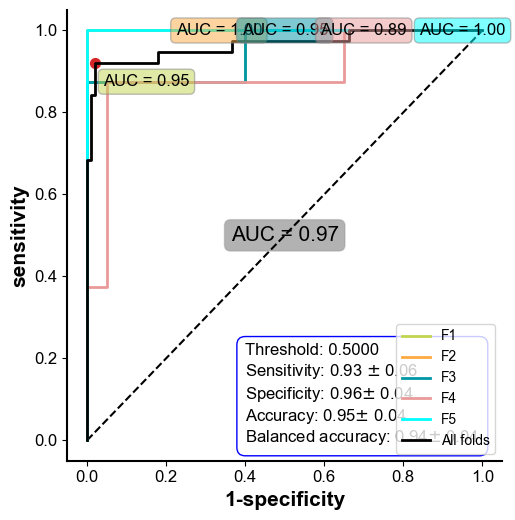

In [36]:
df = pd.concat(dfs, ignore_index=True)
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'k--')
plot_multi_roc_curves(df, pos_label=1, neg_label=0)
plot_roc_curve(df, pos_label=1, neg_label=0, thres=0.5)
plt.legend()
plt.tight_layout(pad=0, h_pad=0, w_pad=0)

today = datetime.now().strftime('%Y%m%d')
# plt.savefig(f'{SAVEDIR}/auc_{today}.svg', bbox_inches='tight', dpi=1000)

## Compare models

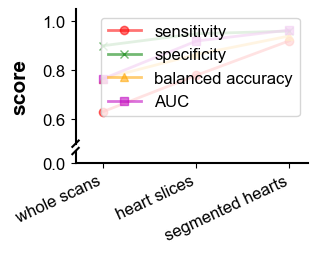

In [23]:
SAVEDIR = f'{HOME}/DATA/INCEPTION_2020-CHD/Mice/PAPER/FIGURES/Sup03/Components'
os.makedirs(SAVEDIR, exist_ok=True)
today = datetime.now().strftime('%Y%m%d')

results = {"heart slices": [0.78, # sens
                            0.95, # specs
                            0.865, # bal acc
                            0.92], # auc
           "whole scans": [0.631579,
                           0.90099,
                           0.766285,
                           0.766285]}

res = calculate_metrics(full_df.prob, full_df.label)
results["segmented hearts"] = [res["sens"],
                               res["spec"],
                               res["bal_acc"],
                               res["auc"]]

metrics_name = ["sensitivity",
                "specificity",
                "balanced accuracy",
                "AUC"]

df = pd.DataFrame(columns=metrics_name)

for k, v in results.items():
  df.loc[k, :] = v
  
df.sort_values('balanced accuracy', inplace=True)

markers = ("o", "x", "^", 's')
colors = ("r", "g", 'orange', 'm')

plt.figure(figsize=(3, 2))
ax = brokenaxes(ylims=((0,.05), (0.5, 1.05)), hspace=0.1)
for i, metric in enumerate(metrics_name):
    ax.plot(
        [1,2,3],
        df[metric],"{}-".format(markers[i]), 
        label=metric, 
        linewidth=2, 
        alpha=0.55,
        color=colors[i],
    )
ax.set_xticks([1,2,3], df.index, rotation=25, ha='right');
ax.set_xlim([0.7,3.2])
ax.set_ylabel("score", fontsize=15, weight='bold')
ax.legend(fontsize=12)

plt.savefig(f'{SAVEDIR}/compare_models_{today}.svg', bbox_inches='tight', dpi=1000)

## Prospective and divergent cohorts

In [3]:
pro_df = pd.read_csv(f"{OUTDIR}/all-in/results/best_model.hdf5/followup.csv")
pro_df["fold"] = "prospective"
pro_meta = pd.read_csv(f"{DATADIR}/resampled/followup/metadata_followup.csv")
pro_df["stage"] = pro_df["heart_name"].map(pro_meta.set_index("heart_name").to_dict()["Stage"])

div_df = pd.read_csv(f"{OUTDIR}/all-in/results/best_model.hdf5/Amaia.csv")
div_df["fold"] = "divergent"
div_meta = pd.read_csv(f"{DATADIR}/resampled/Amaia/metadata_Amaia.csv")
div_df["stage"] = div_df["heart_name"].map(div_meta.set_index("heart_name").to_dict()["Stage"])

retrain_df = pd.read_csv(f"{OUTDIR}/retrain/results/best_model.hdf5/Amaia.csv")
retrain_df["fold"] = "retrain"
retrain_df["stage"] = retrain_df["heart_name"].map(div_meta.set_index("heart_name").to_dict()["Stage"])

### Compare retrain

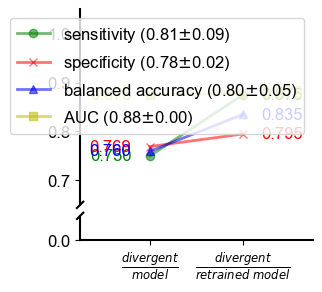

In [4]:
SAVEDIR = f"{HOME}/DATA/INCEPTION_2020-CHD/Mice/PAPER/FIGURES/Fig05/Components"
os.makedirs(SAVEDIR, exist_ok=True)
df = pd.DataFrame({"test": ["divergent", "retrained"]})
dfs = [div_df, retrain_df]
df["sensitivity"] = [metrics.recall_score(x["label"], x["pred"], pos_label=1) for x in dfs]
df["specificity"] = [metrics.recall_score(x["label"], x["pred"], pos_label=0) for x in dfs]
df["balanced accuracy"] = [metrics.balanced_accuracy_score(x["label"], x["pred"]) for x in dfs]
df["AUC"] = [metrics.roc_auc_score(x["label"], x["prob"]) for x in dfs]
df.set_index("test", inplace=True)

markers = ("o", "x", "^", 's')
colors = ('g', 'r', 'b', 'y')
metrics_name = df.columns.to_list()

plt.figure(figsize=(3, 3))
ax = brokenaxes(ylims=((0,.05), (0.65, 1.05)), hspace=0.1)
ax.set_xlim([0.25,2.75])
for i, metric in enumerate(metrics_name):
    ax.plot(
        [1,2],
        df[metric],"{}-".format(markers[i]), 
        label=metric + " ({:.2f}".format(np.round(df[metric].mean(),2)) + "$\pm$" + "{:.2f})".format(df[metric].std()), 
        linewidth=2, 
        alpha=0.55,
        color=colors[i],
    )
    
    ax.text(0.8, df.loc["divergent", metric],
            "{:.3f}".format(df.loc["divergent", metric]),
            ha="right", va="center", fontsize=12, color=colors[i])
    
    ax.text(2.2, df.loc["retrained", metric],
            "{:.3f}".format(df.loc["retrained", metric]),
            ha="left", va="center", fontsize=12, color=colors[i])
    
ax.set_xticks([1,2],
              [
                #   r"$\frac{prospective}{model}$", 
               r"$\frac{divergent}{model}$", 
               r"$\frac{divergent}{retrained\ model}$"])

    
ax.legend(fontsize=12)

today = datetime.now().strftime('%Y%m%d')
# plt.tight_layout(pad=0, h_pad=0, w_pad=0)
# plt.savefig(os.path.join(SAVEDIR, f'compare_retrain_{today}.svg'), bbox_inches='tight', dpi=1000)

### ROC

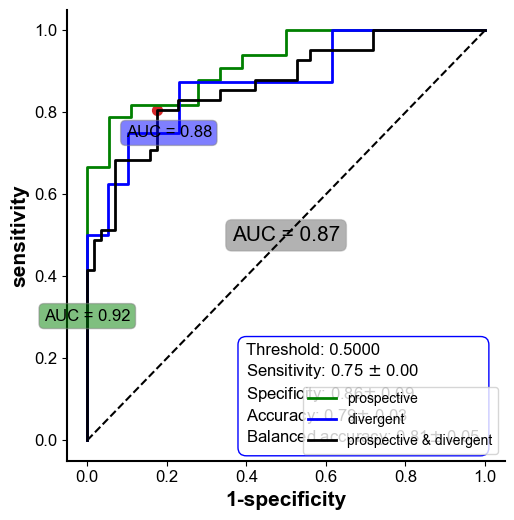

In [9]:
df = pd.concat([pro_df, div_df], ignore_index=True)
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'k--')
plot_multi_roc_curves(df, colors=["g", "b", "y"], pos_label=1, neg_label=0)
plot_roc_curve(df, pos_label=1, neg_label=0, thres=0.5, label="prospective & divergent")
plt.legend()
plt.tight_layout(pad=0, h_pad=0, w_pad=0)

today = datetime.now().strftime('%Y%m%d')
# plt.savefig(os.path.join(SAVEDIR, f'roc_{today}.svg'), bbox_inches='tight', dpi=1000)

In [10]:
df = pro_df.copy()
calculate_metrics(df.prob, df.label), len(df)

({'acc': 0.8235294117647058,
  'bal_acc': 0.851010101010101,
  'all_sens': array([0.75757576]),
  'all_spec': array([0.94444444]),
  'all_f1': array([0.84745763]),
  'all_auc': array([0.92087542]),
  'sens': 0.7575757575757576,
  'spec': 0.9444444444444444,
  'f1': 0.8474576271186441,
  'auc': 0.9208754208754208},
 51)

In [11]:
df = div_df.copy()
calculate_metrics(df.prob, df.label), len(df)

({'acc': 0.7659574468085106,
  'bal_acc': 0.7596153846153846,
  'all_sens': array([0.75]),
  'all_spec': array([0.76923077]),
  'all_f1': array([0.52173913]),
  'all_auc': array([0.875]),
  'sens': 0.75,
  'spec': 0.7692307692307693,
  'f1': 0.5217391304347827,
  'auc': 0.875},
 47)

In [12]:
df = retrain_df.copy()
calculate_metrics(df.prob, df.label), len(df)

({'acc': 0.8085106382978723,
  'bal_acc': 0.8349358974358974,
  'all_sens': array([0.875]),
  'all_spec': array([0.79487179]),
  'all_f1': array([0.60869565]),
  'all_auc': array([0.87820513]),
  'sens': 0.875,
  'spec': 0.7948717948717948,
  'f1': 0.608695652173913,
  'auc': 0.8782051282051282},
 47)

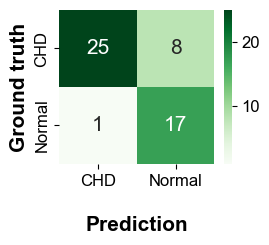

In [13]:
df = pro_df.copy()
df["label"] = df["label"].map(decode_label)
df["pred"] = df["pred"].map(decode_label)
plt.subplots(figsize=(2.5,2))
plot_cm_binary(
    df,
    cmap="Greens",
    normalize=False,
    fmt='d'
)

today = datetime.now().strftime('%Y%m%d')
# plt.savefig(os.path.join(SAVEDIR, f'cf_pro_{today}.svg'), bbox_inches='tight', dpi=1000)

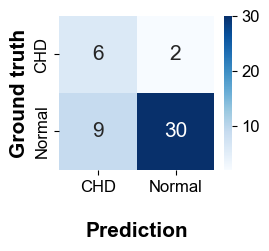

In [14]:
df = div_df.copy()
df["label"] = df["label"].map(decode_label)
df["pred"] = df["pred"].map(decode_label)
plt.subplots(figsize=(2.5,2))
plot_cm_binary(
    df,
    cmap="Blues",
    normalize=False,
    fmt='d'
)

today = datetime.now().strftime('%Y%m%d')
# plt.savefig(os.path.join(SAVEDIR, f'cf_div_{today}.svg'), bbox_inches='tight', dpi=1000)

{'acc': 0.7959183673469388, 'bal_acc': 0.7903294822421909, 'all_sens': array([0.75609756]), 'all_spec': array([0.8245614]), 'all_f1': array([0.75609756]), 'all_auc': array([0.86649551]), 'sens': 0.7560975609756098, 'spec': 0.8245614035087719, 'f1': 0.7560975609756099, 'auc': 0.8664955070603337} 98


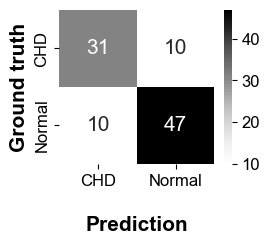

In [15]:
df = pd.concat([pro_df, div_df], ignore_index=True)
print(calculate_metrics(df.prob, df.label), len(df))
df["label"] = df["label"].map(decode_label)
df["pred"] = df["pred"].map(decode_label)
plt.subplots(figsize=(2.5,2))
plot_cm_binary(
    df,
    cmap="Greys",
    normalize=False,
    fmt='d'
)

today = datetime.now().strftime('%Y%m%d')
# plt.savefig(os.path.join(SAVEDIR, f'cf_{today}.svg'), bbox_inches='tight', dpi=1000)

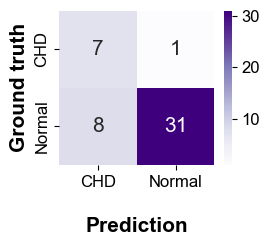

In [16]:
df = retrain_df.copy()
df["label"] = df["label"].map(decode_label)
df["pred"] = df["pred"].map(decode_label)
plt.subplots(figsize=(2.5,2))
plot_cm_binary(
    df,
    cmap="Purples",
    normalize=False,
    fmt='d'
)

today = datetime.now().strftime('%Y%m%d')
# plt.savefig(os.path.join(SAVEDIR, f'cf_retrain_{today}.svg'), bbox_inches='tight', dpi=1000)

<Figure size 300x300 with 0 Axes>

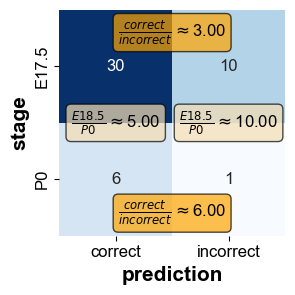

In [196]:
df = div_df.copy()
df['prediction'] = (df['label']==df['pred'])*1
df['prediction'] = df['prediction'].map({1: "correct", 0: "incorrect"})
tb = pd.crosstab(df["stage"], df["prediction"])
plt.figure(figsize=(3,3))
plt.figure(figsize=(2.75,2.75))
sns.heatmap(tb, 
            annot=True, 
            annot_kws={"size": 12}, 
            fmt='d', 
            cmap="Blues",
            cbar=False
           )
chd_per_normal = tb["correct"]/tb["incorrect"]
e185_per_p0 = tb.loc["E17.5", :]/tb.loc["P0", :]

props1 = dict(boxstyle='round', facecolor='orange', alpha=0.7)
props2 = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
plt.text(1,0.2, 
         r'$\frac{correct}{incorrect}\approx$' + '{:.2f}'.format(chd_per_normal['E17.5']),
         fontsize=12, va='center', ha='center', bbox=props1)
plt.text(1,1.8, 
         r'$\frac{correct}{incorrect}\approx$' + '{:.2f}'.format(chd_per_normal['P0']),
         fontsize=12, va='center', ha='center', bbox=props1)

plt.text(0.5,1, 
         r'$\frac{E18.5}{P0}\approx$' + '{:.2f}'.format(e185_per_p0["correct"]),
         fontsize=12, va='center', ha='center', bbox=props2)
plt.text(1.5,1, 
         r'$\frac{E18.5}{P0}\approx$' + '{:.2f}'.format(e185_per_p0["incorrect"]),
         fontsize=12, va='center', ha='center', bbox=props2)

plt.xlabel('prediction', fontsize=15, weight='bold')
plt.ylabel('stage', fontsize=15, weight='bold')

plt.tight_layout(pad=0, h_pad=0, w_pad=0)

today = datetime.now().strftime('%Y%m%d')

In [195]:
ChiSqResult = stats.chi2_contingency(tb)
ChiSqResult

Chi2ContingencyResult(statistic=0.7657868629908103, pvalue=0.38152358396015074, dof=1, expected_freq=array([[32.34042553,  7.65957447],
       [ 5.65957447,  1.34042553]]))

## Volumes

In [17]:
from tqdm import  tqdm
from mousechd.datasets.utils import get_largest_connectivity

def calc_volumes(maskdir, savedir, resampled_file, metadata_file):
    os.makedirs(savedir, exist_ok=True)
    try:
        volume_df = pd.read_csv(os.path.join(savedir, "volumes.csv"))
    except FileNotFoundError:
        volume_df = pd.read_csv(resampled_file)
        volume_df["volume"] = None
        
        for idx, f, spacing in tqdm(zip(volume_df.index.tolist(),
                                        volume_df.heart_name.tolist(),
                                        volume_df.resampled_spacing.tolist())):
            spacing = eval(spacing)
            mask = sitk.ReadImage(os.path.join(maskdir, f))
            mask = sitk.GetArrayFromImage(mask)
            bin_mask = mask.copy()
            bin_mask[bin_mask != 0] = 1
            max_clump = get_largest_connectivity(bin_mask)
            mask[max_clump==0] = 0
            
            vol = (mask != 0).sum()
            
            volume_df.loc[idx, "volume"] = vol*spacing[0]*spacing[1]*spacing[2]
        
        volume_df[["heart_name", "volume"]].to_csv(os.path.join(savedir, "volumes.csv"), index=False)
        
    meta_df = pd.read_csv(metadata_file)
    meta_df["label"] = (meta_df["Normal heart"] == 0)*1
    volume_df["stage"] = volume_df["heart_name"].map(meta_df.set_index("heart_name").to_dict()["Stage"])
    volume_df["label"] = volume_df["heart_name"].map(meta_df.set_index("heart_name").to_dict()["label"])
    
    return volume_df[["heart_name", "volume", "stage", "label"]]
    
            

In [18]:
imagine_vol_df = calc_volumes(maskdir=os.path.join(OUTDIR, "../HeartSeg/Imagine"), 
                              savedir=f"{DATADIR}/processed/Imagine", 
                              resampled_file=f"{DATADIR}/resampled/Imagine/resampled.csv", 
                              metadata_file=f"{DATADIR}/resampled/Imagine/metadata_20210203.csv")

In [19]:
pro_vol_df = calc_volumes(maskdir=os.path.join(OUTDIR, "../HeartSeg/followup"), 
                          savedir=f"{DATADIR}/processed/followup", 
                          resampled_file=f"{DATADIR}/resampled/followup/resampled.csv", 
                          metadata_file=f"{DATADIR}/resampled/followup/metadata_followup.csv")

In [20]:
div_vol_df = calc_volumes(maskdir=os.path.join(OUTDIR, "../HeartSeg/Amaia"), 
                          savedir=f"{DATADIR}/processed/Amaia", 
                          resampled_file=f"{DATADIR}/resampled/Amaia/resampled.csv", 
                          metadata_file=f"{DATADIR}/resampled/Amaia/metadata_Amaia.csv")

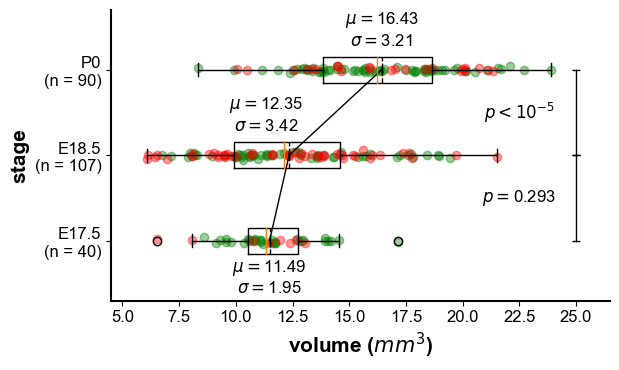

In [21]:
volume_df = pd.concat([imagine_vol_df, pro_vol_df, div_vol_df], ignore_index=True)
volume_df["label"] = volume_df["label"].map(decode_label)

today = datetime.now().strftime('%Y%m%d')

vals, names, xs, labels = [], [], [], []

stages = ["E17.5", "E18.5","P0"]

for i, stage in enumerate(stages):
    vals.append(volume_df[volume_df["stage"]==stage]["volume"].values)
    labels.append(volume_df[volume_df["stage"]==stage]["label"].values)
    names.append("{}\n(n = {})".format(stage, len(volume_df[volume_df["stage"]==stage])))
    xs.append(np.random.normal(i+1, 0.02, volume_df[volume_df["stage"]==stage]["volume"].values.shape[0]))
    
plt.figure(figsize=(6,3.5))
plt.boxplot(vals, labels=names, 
            meanline=True, showmeans=True,
            meanprops={'color': 'k'},
            vert=False
           )

palette = ["r", "g"]
for x, val, label in zip(vals, xs, labels):
    normal_idx = (label == "Normal")
    ab_idx = (label == "CHD")
    plt.scatter(x[normal_idx], val[normal_idx], alpha=0.4, color="g", label="Normal")
    plt.scatter(x[ab_idx], val[ab_idx], alpha=0.4, color="r", label="CHD")
    
# Mean
plt.text(vals[0].mean(), 0.8,
         r'$\mu=$' + '{:.2f}\n'.format(vals[0].mean()) + r'$\sigma=$' + '{:.2f}\n'.format(np.std(vals[0])),
         ha="center", va="top",
         fontsize=12
        );

plt.text(vals[1].mean()-1, 2.7,
         r'$\mu=$' + '{:.2f}\n'.format(vals[1].mean()) + r'$\sigma=$' + '{:.2f}\n'.format(np.std(vals[1])),
         ha="center", va="top",
         fontsize=12
        );

plt.text(vals[2].mean(), 3.7,
         r'$\mu=$' + '{:.2f}\n'.format(vals[2].mean()) + r'$\sigma=$' + '{:.2f}\n'.format(np.std(vals[2])),
         ha="center", va="top",
         fontsize=12
        );

plt.plot([vals[0].mean(), vals[1].mean()], [1,2], '|-k', linewidth=1)
plt.plot([vals[1].mean(), vals[2].mean()], [2,3], '|-k', linewidth=1)

# # test
plt.plot([25,25], [1,2], linewidth=1, c="k", marker="_")
plt.plot([25,25], [2,3], linewidth=1, c="k", marker="_")

# plt.text(20, 1.65,
#         #  "t-test",
#         #  "Wilcoxon signed-rank test",
#          "Mann-Whitney U test",
#          weight="bold",
#          ha="center", va="center",
#          fontsize=12
#         );

# plt.text(20, 1.3,
#          r'$p=$' + '{:.3f} '.format(
#             #  stats.ttest_ind(vals[0], vals[1]).pvalue
#             #  stats.wilcoxon(vals[0], vals[1]).pvalue
#              stats.mannwhitneyu(vals[0], vals[1]).pvalue
#          ) + "\n(n1 = {}, n2 = {})".format(len(vals[0]), len(vals[1])),
#          ha="center", va="center",
#          fontsize=12
#         );
plt.text(22.5, 1.5,
         r'$p=$' + '{:.3f}'.format(
            #  stats.ttest_ind(vals[0], vals[1]).pvalue
            #  stats.wilcoxon(vals[0], vals[1]).pvalue
             stats.mannwhitneyu(vals[0], vals[1]).pvalue
         ), ha="center", va="center",
         fontsize=12
        );
plt.text(22.5, 2.5,
         r'$p<10^{-5}$',
         ha="center", va="center",
         fontsize=12
        );


plt.xlim(4.5,26.5)
plt.ylim(0.3, 3.7)
plt.xlabel("volume ($mm^3$)", fontsize=15, weight='bold')
plt.ylabel("stage", fontsize=15, weight='bold')
plt.tight_layout(pad=0, h_pad=0, w_pad=0)
today = datetime.now().strftime('%Y%m%d')
# plt.savefig(os.path.join(SAVEDIR, f'volumes_{today}.svg'), bbox_inches='tight', dpi=1000)

In [22]:
stats.mannwhitneyu(vals[0], vals[1])

MannwhitneyuResult(statistic=1898.0, pvalue=0.2932004605039358)

In [24]:
len(vals[0]), len(vals[1])

(40, 107)